# Chapter 7. 回帰分析の悩みどころ

In [1]:
import pandas as pd
import numpy as np
import pystan
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/Users/takashi_miyamoto/.pyenv/versions/anaconda3-2.1.0/lib/python3.4/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## 7.2 対数をとるか否か

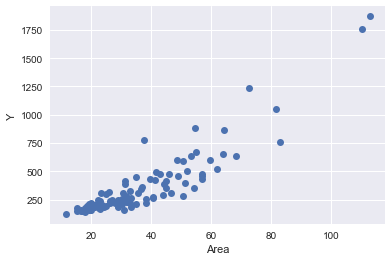

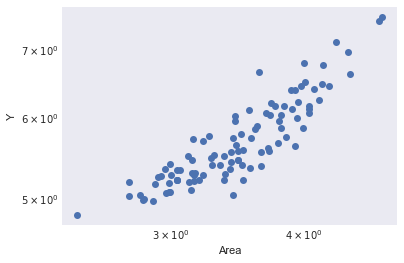

In [2]:
df_1 = pd.read_csv('input/data-rental.txt')
data_1 = df_1.to_dict('list')
data_1['N'] = len(df_1)
data_1['Area_new'] = np.linspace(5, 120, 115)
data_1['N_new'] = len(data_1['Area_new'])
plt.plot(df_1['Area'], df_1['Y'], "o")
plt.xlabel('Area')
plt.ylabel('Y')
plt.show()
plt.plot(df_1['Area'].apply(np.log), df_1['Y'].apply(np.log), "o")
plt.xlabel('Area')
plt.ylabel('Y')
plt.xscale('log')
plt.yscale('log')
plt.show()

最初に変数変換しない場合

In [3]:
model_1 = """
data {
  int N;
  int N_new;
  real<lower=0> Area[N];
  real<lower=0> Area_new[N_new];
  real<lower=0> Y[N];
}

parameters {
  real b1;
  real b2;
  real<lower=0> sigma;
}

transformed parameters {
  real mu[N];
  for (n in 1:N)
    mu[n] = b1 + b2*Area[n];
}

model {
  for (n in 1:N)
    Y[n] ~ normal(mu[n], sigma);
}

generated quantities {
  real y_pred[N];
  real e[N];
  real Y_new[N_new];
  for (n in 1:N) {
    y_pred[n] = normal_rng(mu[n], sigma);
    e[n] = Y[n] - mu[n];
  }
  for (n in 1:N_new)
    Y_new[n] = normal_rng(b1 + b2*Area_new[n], sigma);
}
"""

In [4]:
fit_1 = pystan.stan(model_code=model_1, data=data_1, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dffa785f8bf96733d0810edf7784b90c NOW.


In [5]:
print(fit_1)

Inference for Stan model: anon_model_dffa785f8bf96733d0810edf7784b90c.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b1         -147.5    1.02  29.58 -203.4 -167.8 -148.6 -127.1 -89.91    844    1.0
b2          13.99    0.03   0.73  12.57  13.49   14.0  14.49  15.37    781    1.0
sigma       130.8    0.27   9.27 114.48 124.05 130.39 136.66 150.18   1144    1.0
mu[0]      421.25     0.3  13.49  394.1  412.2 421.23 430.04 448.55   2000    1.0
mu[1]      718.95    0.68  22.73  673.3 703.64 718.68 734.58 765.15   1122    1.0
mu[2]      623.68    0.52  18.91 586.39 611.09 623.85 636.55 662.86   1328    1.0
mu[3]      647.32    0.56  19.81 608.02 634.07 647.44 660.77 688.23   1262    1.0
mu[4]      647.32    0.56  19.81 608.02 634.07 647.44 660.77 688.23   1262    1.0
mu[5]       69.27    0.64  20.11   31.3  55.27  69.03  82.88 108.61   1000 

予測分布を書く関数

In [6]:
def plot_pred_range(fit, xs, ys_key, percentiles, alpha):
    ys = (fit.extract(permuted=True))[ys_key].T
    plt.fill_between( \
        xs, \
        [np.percentile(y, percentiles[0]) for y in ys], \
        [np.percentile(y, percentiles[1]) for y in ys], alpha=alpha)

予測分布

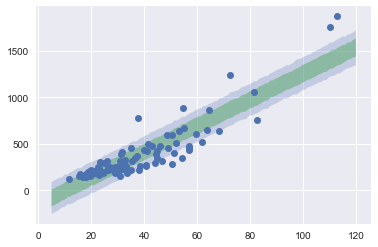

In [7]:
plt.plot(data_1['Area'], data_1['Y'], "o")
plot_pred_range(fit_1, data_1['Area_new'], 'Y_new', (10, 90), 0.25)
plot_pred_range(fit_1, data_1['Area_new'], 'Y_new', (25, 75), 0.5)
plt.show()

誤差のヒストグラム

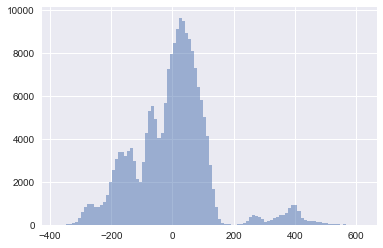

In [8]:
def hist_error(fit):
    plt.hist((fit.extract(permuted=True))['e'].flatten(), bins=100, alpha=0.5);
hist_error(fit_1)

変数変換する場合

In [9]:
model_1a = """
data {
  int N;
  int N_new;
  real<lower=0> Area[N];
  real<lower=0> Area_new[N_new];
  real<lower=0> Y[N];
}

parameters {
  real b1;
  real b2;
  real<lower=0> sigma;
}

transformed parameters {
  real mu[N];
  for (n in 1:N)
    mu[n] = b1 + b2*log(Area[n]);
}

model {
  for (n in 1:N)
    log(Y[n]) ~ normal(mu[n], sigma);
}

generated quantities {
  real y_pred[N];
  real e[N];
  real Y_new[N_new];
  for (n in 1:N) {
    y_pred[n] = exp(normal_rng(mu[n], sigma));
    e[n] = log(Y[n]) - mu[n];
  }
  for (n in 1:N_new)
    Y_new[n] = exp(normal_rng(b1 + b2*log(Area_new[n]), sigma));
}
"""

In [10]:
fit_1a = pystan.stan(model_code=model_1a, data=data_1, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_782ff4b375e8941d35cf9a11725ee848 NOW.


In [11]:
print(fit_1a)

Inference for Stan model: anon_model_782ff4b375e8941d35cf9a11725ee848.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b1           1.85  6.6e-3   0.19   1.48   1.72   1.84   1.97    2.2    807    1.0
b2           1.11  1.9e-3   0.05   1.01   1.07   1.11   1.14   1.21    798    1.0
sigma        0.26  7.4e-4   0.02   0.22   0.24   0.26   0.27    0.3    724   1.01
mu[0]        5.94  6.9e-4   0.03   5.89   5.92   5.94   5.96    6.0   1598    1.0
mu[1]        6.41  1.3e-3   0.04   6.33   6.38   6.41   6.44   6.49   1053    1.0
mu[2]        6.28  1.1e-3   0.04   6.21   6.25   6.28    6.3   6.35   1141    1.0
mu[3]        6.31  1.1e-3   0.04   6.24   6.29   6.31   6.34   6.39   1116    1.0
mu[4]        6.31  1.1e-3   0.04   6.24   6.29   6.31   6.34   6.39   1116    1.0
mu[5]        4.88  1.5e-3   0.05   4.78   4.84   4.88   4.91   4.97    966 

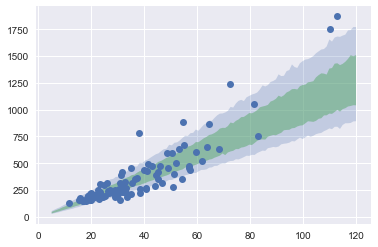

In [12]:
plt.plot(data_1['Area'], data_1['Y'], "o")
plot_pred_range(fit_1a, data_1['Area_new'], 'Y_new', (10, 90), 0.25)
plot_pred_range(fit_1a, data_1['Area_new'], 'Y_new', (25, 75), 0.5)
plt.show()

誤差分布は多少左右対称に近づいたと言える。

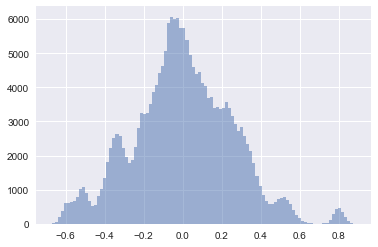

In [13]:
hist_error(fit_1a)

## 7.3 非線形の関係

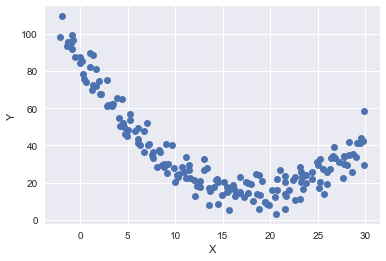

In [14]:
df_2 = pd.read_csv('input/data-aircon.txt')
data_2 = df_2.to_dict('list')
data_2['N'] = len(df_2)
data_2['X_new'] = np.linspace(-5, 35, 40)
data_2['N_new'] = len(data_2['X_new'])
plt.plot(df_2['X'], df_2['Y'], "o")
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [15]:
model_2 = """
data {
  int N;
  real X[N];
  real Y[N];
  int N_new;
  real X_new[N_new];
}

parameters {
  real a;
  real <lower=0> b;
  real <lower=0, upper=30> x0;
  real <lower=0> s_Y;
}

model {
  for (n in 1:N)
    Y[n] ~ normal(a+b*(X[n]-x0)^2, s_Y);
}

generated quantities {
  real y_new[N_new];
  real e[N];
  for (n in 1:N)
    e[n] = Y[n] - (a+b*(X[n]-x0)^2);
  for (n in 1:N_new)
    y_new[n] = normal_rng(a+b*(X_new[n]-x0)^2, s_Y);
}
"""

In [16]:
fit_2 = pystan.stan(model_code=model_2, data=data_2, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_66bddfdc9eac3be7a917ee560c420b40 NOW.


In [17]:
print(fit_2)

Inference for Stan model: anon_model_66bddfdc9eac3be7a917ee560c420b40.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a          14.19    0.02   0.57  13.06   13.8  14.16  14.55   15.4   1164    1.0
b           0.21  1.9e-4 5.6e-3    0.2   0.21   0.21   0.22   0.23    891    1.0
x0         18.28  5.0e-3   0.16  17.97  18.17  18.28  18.39  18.57   1035    1.0
s_Y         5.74  7.6e-3   0.31   5.19   5.53   5.72   5.93   6.39   1636    1.0
y_new[0]  130.41    0.14   5.83 118.26 126.53 130.42 134.31  141.6   1794    1.0
y_new[1]  120.31    0.14   5.89 108.49 116.36 120.42 124.27 131.53   1711    1.0
y_new[2]  110.81    0.13    5.9  99.16 106.89 110.92 114.93 121.85   2000    1.0
y_new[3]  101.55    0.13   5.93  90.14  97.57 101.59 105.72 112.83   1988    1.0
y_new[4]   92.98    0.13   5.95  81.14  89.08  93.05  96.94 104.57   1989    1.0
y_n

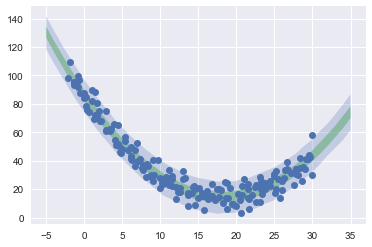

In [18]:
plt.plot(data_2['X'], data_2['Y'], "o")
plot_pred_range(fit_2, data_2['X_new'], 'y_new', (2.5, 97.5), 0.25)
plot_pred_range(fit_2, data_2['X_new'], 'y_new', (25, 75), 0.5)
plt.show()

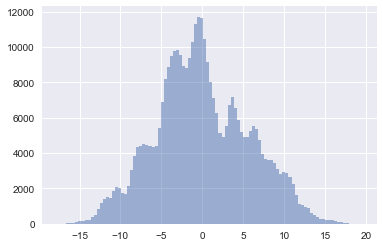

In [19]:
hist_error(fit_2)

In [20]:
df_3 = pd.read_csv('input/data-conc.txt')
df_3

,Time,Y
0,1,2.4
1,2,5.0
2,4,7.5
3,8,11.9
4,12,12.5
5,24,12.7


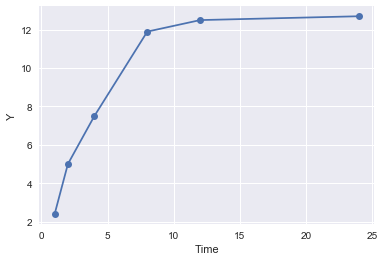

In [21]:
data_3 = df_3.to_dict('list')
data_3['T'] = len(df_3)
data_3['Time_new'] = [np.power(10,x)*24 for x in np.linspace(-2, 0, 40)]
data_3['T_new'] = len(data_3['Time_new'])
plt.plot(df_3['Time'], df_3['Y'], "o-")
plt.xlabel('Time')
plt.ylabel('Y')
#plt.xscale('log')
plt.show()

In [22]:
model_3 = """
data {
  int T;
  real Time[T];
  real Y[T];
  int T_new;
  real Time_new[T_new];
}

parameters {
  real<lower=0, upper=100> a;
  real<lower=0, upper=5> b;
  real<lower=0> s_Y;
}

model {
  for (t in 1:T)
    Y[t] ~ normal(a*(1-exp(-b*Time[t])), s_Y);
}

generated quantities {
  real y_new[T_new];
  for (t in 1:T_new)
    y_new[t] = normal_rng(a*(1-exp(-b*Time_new[t])), s_Y);
}
"""

In [23]:
fit_3 = pystan.stan(model_code=model_3, data=data_3, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_47132d80a244d8a280377ac5bfc34675 NOW.


In [24]:
print(fit_3)

Inference for Stan model: anon_model_47132d80a244d8a280377ac5bfc34675.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a          13.18    0.06   1.02  11.61  12.73  13.12  13.53  14.85    281   1.02
b           0.24  2.1e-3   0.05   0.16   0.22   0.24   0.26   0.35    548   1.01
s_Y         0.88    0.04   0.69   0.34   0.53   0.69   0.98   2.56    240   1.02
y_new[0]    0.73    0.03   1.16  -1.34   0.27   0.74   1.22   2.66   1636    1.0
y_new[1]     0.8    0.03   1.17  -1.31   0.33   0.81   1.28   2.82   1635    1.0
y_new[2]    0.93    0.03    1.1  -1.04   0.44   0.91   1.41    2.9   1834    1.0
y_new[3]    1.05    0.02   1.08  -1.02   0.58   1.01   1.48   3.25   2000    1.0
y_new[4]    1.15    0.03    1.2  -0.92   0.69   1.14   1.64   3.25   2000    1.0
y_new[5]    1.28    0.03   1.13  -0.96    0.8    1.3   1.76   3.28   1576    1.0
y_n

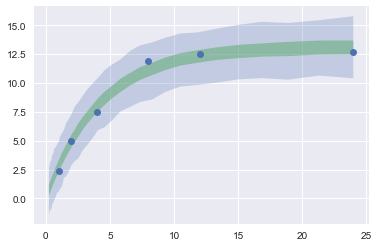

In [25]:
plt.plot(data_3['Time'], data_3['Y'], "o")
plot_pred_range(fit_3, data_3['Time_new'], 'y_new', (2.5, 97.5), 0.25)
plot_pred_range(fit_3, data_3['Time_new'], 'y_new', (25, 75), 0.5)
#plt.xscale('log')
plt.show()

## 7.5 交絡

In [26]:
df_4 = pd.read_csv('input/data-50m.txt')
df_4.head()

,Y,Weight,Age
0,2.46,16.6,7
1,3.02,21.4,7
2,2.91,24.0,7
3,3.05,13.0,7
4,2.60,21.9,7


年齢を考慮しないと、WeightとYには正の相関がある。

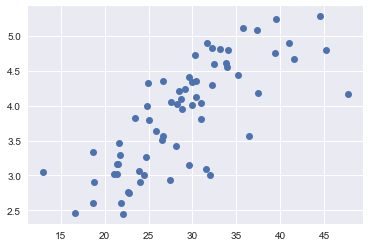

In [27]:
plt.plot(df_4['Weight'], df_4['Y'], "o")

Ageで層別すると、WeightとYには負の相関。

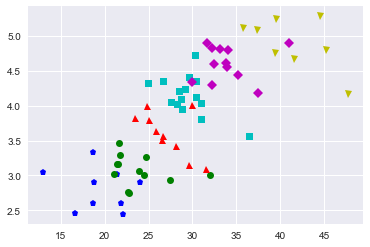

In [28]:
clrs = ['b', 'g', 'r', 'c', 'm', 'y']
syms = ['bp', 'go', 'r^', 'cs', 'mD', 'yv']
for x in range(7, 13):
    df = df_4[df_4['Age'] == x]
    plt.plot(df['Weight'], df['Y'], syms[x-7])
plt.show()

In [29]:
data_4 = df_4.to_dict('list')
data_4['N'] = len(df_4)
data_4['Weight_new'] = np.linspace(10, 50, 40)
data_4['N_new'] = len(data_4['Weight_new'])

In [30]:
model_4 = """
data {
  int N;
  real Weight[N];
  real Y[N];
  int Age[N];
  int N_new;
  real Weight_new[N_new];
}

parameters {
  real c1;
  real c2;
  real<lower=0> sigma_W;
  real b1;
  real b2;
  real b3;
  real<lower=0> sigma_Y;
}

transformed parameters {
  real mu_Weight[N];
  real mu_Y[N];
  for (n in 1:N) {
    mu_Weight[n] = c1 + c2*Age[n];
    mu_Y[n] = b1 + b2*Age[n] + b3*Weight[n];
  }
}

model {
  for (n in 1:N) {
    Weight[n] ~ normal(mu_Weight[n], sigma_W);
    Y[n] ~ normal(mu_Y[n], sigma_Y);
  }
}

generated quantities {
  real y7_new[N_new];
  real y8_new[N_new];
  real y9_new[N_new];
  real y10_new[N_new];
  real y11_new[N_new];
  real y12_new[N_new];
  for (n in 1:N_new) {
    y7_new[n] = normal_rng(b1+b2*7+b3*Weight_new[n], sigma_Y);
    y8_new[n] = normal_rng(b1+b2*8+b3*Weight_new[n], sigma_Y);
    y9_new[n] = normal_rng(b1+b2*9+b3*Weight_new[n], sigma_Y);
    y10_new[n] = normal_rng(b1+b2*10+b3*Weight_new[n], sigma_Y);
    y11_new[n] = normal_rng(b1+b2*11+b3*Weight_new[n], sigma_Y);
    y12_new[n] = normal_rng(b1+b2*12+b3*Weight_new[n], sigma_Y);
  }
}
"""

In [31]:
fit_4 = pystan.stan(model_code=model_4, data=data_4, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5c7ad1414e2e98f8456729f2f6594b40 NOW.


In [32]:
print(fit_4)

Inference for Stan model: anon_model_5c7ad1414e2e98f8456729f2f6594b40.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c1             -8.67    0.08   2.42 -13.49 -10.24  -8.62  -7.07  -3.84    895    1.0
c2              3.96  8.5e-3   0.25   3.47    3.8   3.96   4.13   4.48    878    1.0
sigma_W         3.31  7.4e-3   0.31   2.76   3.09   3.29   3.49    4.0   1773    1.0
b1             -0.72  6.1e-3   0.22  -1.15  -0.87  -0.73  -0.56  -0.26   1357    1.0
b2              0.59  1.5e-3   0.05   0.49   0.56   0.59   0.62   0.68   1042    1.0
b3             -0.04  3.1e-4   0.01  -0.06  -0.04  -0.03  -0.03  -0.01   1176    1.0
sigma_Y         0.27  6.1e-4   0.02   0.23   0.25   0.27   0.29   0.32   1565    1.0
mu_Weight[0]   19.08    0.02   0.75  17.61   18.6  19.08  19.57  20.58   1139    1.0
mu_Weight[1]   19.08    0.02   0.75  17.61   18.

年齢別の50%予測区間を、年齢別に分けたプロットに重ねてみる

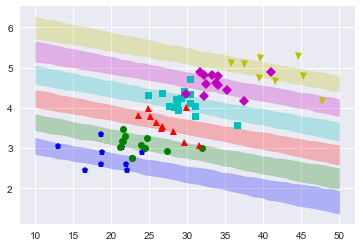

In [33]:
def f_fill(ys_key, c):
    ys = (fit_4.extract(permuted=True))[ys_key].T
    plt.fill_between( \
        data_4['Weight_new'], \
        [np.percentile(y, 25) for y in ys], \
        [np.percentile(y, 75) for y in ys], color=c, alpha=0.25)
for x in range(7, 13):
    df = df_4[df_4['Age'] == x]
    plt.plot(df['Weight'], df['Y'], syms[x-7])
f_fill('y7_new', clrs[0])
f_fill('y8_new', clrs[1])
f_fill('y9_new', clrs[2])
f_fill('y10_new', clrs[3])
f_fill('y11_new', clrs[4])
f_fill('y12_new', clrs[5])
plt.show()

## 7.7 説明変数にノイズを含む

In [34]:
df_5 = pd.read_csv('../Chap04/input/data-salary.txt')
df_5.head()

,X,Y
0,24,472
1,24,403
2,26,454
3,32,575
4,33,546


In [35]:
data_5 = df_5.to_dict('list')
data_5['N'] = len(df_5)

In [36]:
model_5 = """
data {
  int N;
  real X[N];
  real Y[N];
}

parameters {
  real a;
  real b;
  real x_true[N];
  real<lower=0> s_Y;
}

model {
  for (n in 1:N) {
    X[n] ~ normal(x_true[n], 2.5);
    Y[n] ~ normal(a + b*x_true[n], s_Y);
  }
}
"""

In [37]:
fit_5 = pystan.stan(model_code=model_5, data=data_5, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_18e207b9d7765370c2018955b5d65f95 NOW.


In [38]:
print(fit_5)

Inference for Stan model: anon_model_18e207b9d7765370c2018955b5d65f95.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a          -121.2    2.25  70.28 -262.2 -166.5 -118.4 -77.88  20.54    979    1.0
b           21.95    0.05   1.58   18.8   21.0  21.89  22.93  25.25    958    1.0
x_true[0]   25.52    0.04   1.92  21.53  24.27  25.61  26.81  29.07   2000    1.0
x_true[1]   23.87    0.04   2.01  19.98  22.48  23.79  25.27  27.75   2000    1.0
x_true[2]   26.15    0.04   1.88  22.35  24.94  26.18  27.41  29.95   2000    1.0
x_true[3]   31.89    0.04   1.83  28.28  30.76  31.85  33.04  35.57   2000    1.0
x_true[4]   31.77    0.04   1.91  28.19  30.46  31.72  32.94  35.78   2000    1.0
x_true[5]   38.02    0.05   2.11  33.51  36.75  38.16  39.52  41.58   2000   1.01
x_true[6]   38.87    0.04   1.96   34.7   37.6  38.92  40.25  42.47   2000 

## 7.8 打ち切り

In [39]:
df_6 = pd.read_csv('input/data-protein.txt')
data_6 = df_6.to_dict('list')
df_6

,Y
0,<25
1,32.3
2,<25
3,28.3
4,30.8
5,35.2


In [40]:
data_6['Y_obs'] = [float(y) for y in data_6['Y'] if not y.startswith('<')]
data_6['N_obs'] = len(data_6['Y_obs'])
data_6['N_cens'] = len([y for y in data_6['Y'] if y.startswith('<')])
data_6['L'] = 25
del data_6['Y']

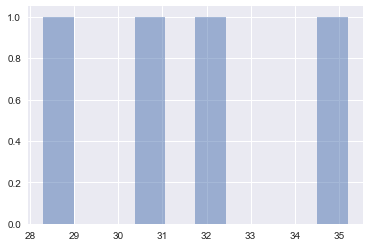

In [41]:
plt.hist(data_6['Y_obs'], bins=10, alpha=0.5);

In [42]:
model_6 = """
data {
  int N_obs;
  int N_cens;
  real Y_obs[N_obs];
  real L;
}

parameters {
  real mu;
  real<lower=0> s_Y;
}

model {
  for (n in 1:N_obs)
    Y_obs[n] ~ normal(mu, s_Y);
  target += N_cens * normal_lcdf(L | mu, s_Y);
}
"""

In [43]:
fit_6 = pystan.stan(model_code=model_6, data=data_6, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a91441ec8e91a4096d633b0c21623918 NOW.


In [44]:
print(fit_6)

Inference for Stan model: anon_model_a91441ec8e91a4096d633b0c21623918.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    25.95    0.64   9.08   8.71  23.72  27.39  29.76  37.47    201   1.01
s_Y   13.42    0.89  14.55   3.81   6.31   9.31  14.87  50.59    270   1.01
lp__ -10.18    0.08   1.34 -13.83 -10.81  -9.77  -9.19  -8.84    280   1.01

Samples were drawn using NUTS at Fri Apr  7 18:44:21 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


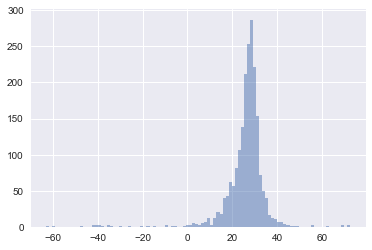

In [45]:
plt.hist((fit_6.extract(permuted=True))['mu'], bins=100, alpha=0.5);

## 7.9 外れ値

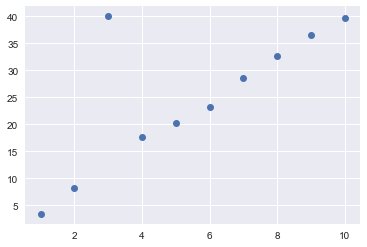

In [46]:
df_7 = pd.read_csv('input/data-outlier.txt')
data_7 = df_7.to_dict('list')
plt.plot(data_7['X'], data_7['Y'], 'o')

最初に正規分布でやってみる

In [47]:
data_7['N'] = len(data_7['X'])
data_7['X_new'] = np.linspace(0, 11, 55)
data_7['N_new'] = len(data_7['X_new'])

In [48]:
model_7a = """
data {
  int N;
  real X[N];
  real Y[N];
  int N_new;
  real X_new[N_new];
}

parameters {
  real a;
  real b;
  real<lower=0> sigma;
}

model {
  for (n in 1:N)
    Y[n] ~ normal(a + b*X[n], sigma);
}

generated quantities {
  real y_new[N_new];
  for (n in 1:N_new)
    y_new[n] = normal_rng(a + b*X_new[n], sigma);
}
"""

In [49]:
fit_7a = pystan.stan(model_code=model_7a, data=data_7, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9b5686156e474a8f9f0c50009b840a66 NOW.


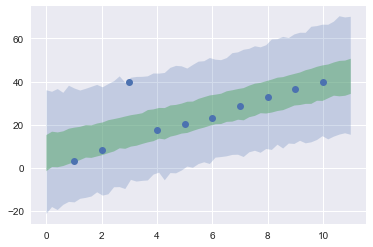

In [50]:
plt.plot(data_7['X'], data_7['Y'], "o")
plot_pred_range(fit_7a, data_7['X_new'], 'y_new', (2.5, 97.5), 0.25)
plot_pred_range(fit_7a, data_7['X_new'], 'y_new', (25, 75), 0.5)
plt.show()

In [51]:
model_7 = """
data {
  int N;
  real X[N];
  real Y[N];
  int N_new;
  real X_new[N_new];
}

parameters {
  real a;
  real b;
  real<lower=0> sigma;
}

model {
  for (n in 1:N)
    Y[n] ~ cauchy(a + b*X[n], sigma);
}

generated quantities {
  real y_new[N_new];
  for (n in 1:N_new)
    y_new[n] = cauchy_rng(a + b*X_new[n], sigma);
}
"""

In [52]:
fit_7 = pystan.stan(model_code=model_7, data=data_7, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e31ca1e60d9a92a263f448ad8763fb24 NOW.


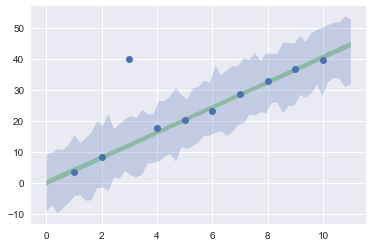

In [53]:
plt.plot(data_7['X'], data_7['Y'], "o")
plot_pred_range(fit_7, data_7['X_new'], 'y_new', (2.5, 97.5), 0.25)
plot_pred_range(fit_7, data_7['X_new'], 'y_new', (25, 75), 0.5)
plt.show()